# Identifying Entities in Healthcare Data

## Workspace set up: Import and Install useful packages.

In [1]:
import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from spacy.tokenizer import Tokenizer
from spacy.lang.en.stop_words import STOP_WORDS

import nltk
from nltk.corpus import words
nltk.download('words')
english_words = set(words.words())

model = spacy.load("en_core_web_sm")
model.tokenizer = Tokenizer(model.vocab)

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


## Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

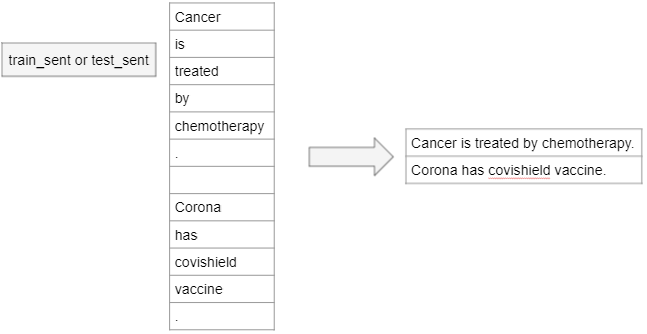

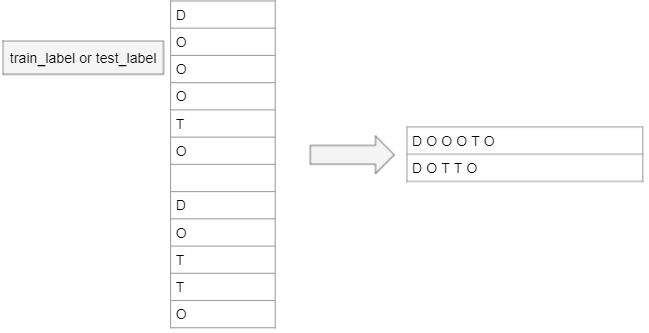

In [2]:
import numpy as np
import pandas as pd

In [3]:
# Function to convert a list of words into a list of complete sentences
def words_2_sentences(words_list):
    current_sentence = []
    sentences_list = []
    for word in words_list:
        if word == '':
            sentences_list.append(' '.join(current_sentence))
            current_sentence = []
        else:
            current_sentence.append(word)
    return sentences_list

In [4]:
# Process the 'train_sent' file
with open('train_sent', 'r') as train_sent_file:
        train_words = [word.strip().replace("\n", "") for word in train_sent_file.readlines()]
train_sentences = words_2_sentences(train_words)

# Process the 'train_label' file
with open('train_label', 'r') as train_label_file:
        train_label = [word.strip().replace("\n", "") for word in train_label_file.readlines()]
train_labels = words_2_sentences(train_label)

# Process the 'test_sent' file
with open('test_sent', 'r') as test_sent_file:
        test_words = [word.strip().replace("\n", "") for word in test_sent_file.readlines()]
test_sentences = words_2_sentences(test_words)

# Process the 'test_label' file
with open('test_label', 'r') as test_label_file:
        test_label = [word.strip().replace("\n", "") for word in test_label_file.readlines()]
test_labels = words_2_sentences(test_label)

In [5]:
# Check for mismatches
for i in range(len(train_sentences)):
    if len(train_sentences[i].split()) != len(train_labels[i].split()):
        print(i, '\n')

In [6]:
# Check whether the sentences have been properly preprocessed.
print('First 5 Train Sentences:')
print('='*20)
for i in range(5):
    print(f'Sentence {i+1}: {train_sentences[i]}')
    print(f'Label {i+1}: {train_labels[i]}')
    print(f'{len(train_sentences[i].split())} Words and {len(train_labels[i].split())} labels\n')

First 5 Train Sentences:
Sentence 1: All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )
Label 1: O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O
45 Words and 45 labels

Sentence 2: The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )
Label 2: O O O O O O O O O O O O O O O O O O O O O O O O O
25 Words and 25 labels

Sentence 3: Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )
Label 3: O O O O O O O O O O O O O O O
15 Words and 15 labels

Sentence 4: The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )
Label 4: O O O O O O O O O O O O O O O O O O O O O O O O O O 

In [7]:
# Check whether the sentences have been properly preprocessed.
print('First 5 Test Sentences:')
print('='*20)
for i in range(5):
    print(f'Sentence {i+1}: {test_sentences[i]}')
    print(f'Label {i+1}: {test_labels[i]}')
    print(f'{len(test_sentences[i].split())} Words and {len(test_labels[i].split())} labels\n')

First 5 Test Sentences:
Sentence 1: Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )
Label 1: O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O
44 Words and 44 labels

Sentence 2: As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration
Label 2: O O O O O O O O O O O O O O O O O O O
19 Words and 19 labels

Sentence 3: The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period
Label 3: O O O O O O O O O O O O O O O O O O O O O O O O
24 Words and 24 labels

Sentence 4: There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 )
Label 4: O O O O O O O O O O O O

### Count the number of sentences in the processed train and test dataset 

In [8]:
# Count the number of sentences
print(f'Number of Sentences in the processed Train dataset: {len(train_sentences)}')
print(f'Number of Sentences in the processed Test dataset: {len(test_sentences)}')

Number of Sentences in the processed Train dataset: 2599
Number of Sentences in the processed Test dataset: 1056


### Count the number of lines of labels in the processed train and test dataset.

In [9]:
# Count the number of lines of labels
print(f'Number of lines of labels in the processed Train dataset: {len(train_labels)}')
print(f'Number of lines of labels in the processed Test dataset: {len(test_labels)}')

Number of lines of labels in the processed Train dataset: 2599
Number of lines of labels in the processed Test dataset: 1056


## Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [10]:
from tqdm import tqdm

# Extract NOUN and PROPN
all_sentences = train_sentences + test_sentences
all_nouns = [(token.text, token.pos_) for doc in tqdm(all_sentences) for token in model(doc) if token.pos_ in {'NOUN', 'PROPN'}]

100%|██████████| 3655/3655 [00:39<00:00, 91.92it/s] 


### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [11]:
# Sort the dictionary and get the top 25 concepts
nouns_df = pd.DataFrame(all_nouns, columns=['Word', 'POS_tag'])
top25_noun_counts_freq = nouns_df['Word'].value_counts().head(25)

# Print the top 25 most common nouns
print("Top 25 Most Common Nouns in the Entire dataset:\n")
print(f"{'Rank':<5} {'Concept':<20} {'Frequency':<10}")
print("=" * 40)
for i, (concept, frequency) in enumerate(top25_noun_counts_freq.items(), 1):
    print(f"{i:<5} {concept:<20} {frequency:<10}")

Top 25 Most Common Nouns in the Entire dataset:

Rank  Concept              Frequency 
1     patients             492       
2     treatment            280       
3     %                    247       
4     cancer               199       
5     therapy              175       
6     study                153       
7     disease              135       
8     lung                 113       
9     cell                 103       
10    group                89        
11    chemotherapy         88        
12    gene                 86        
13    effects              85        
14    women                77        
15    results              77        
16    use                  73        
17    cases                71        
18    surgery              70        
19    rate                 67        
20    risk                 66        
21    analysis             64        
22    children             64        
23    survival             63        
24    effect               62        
2

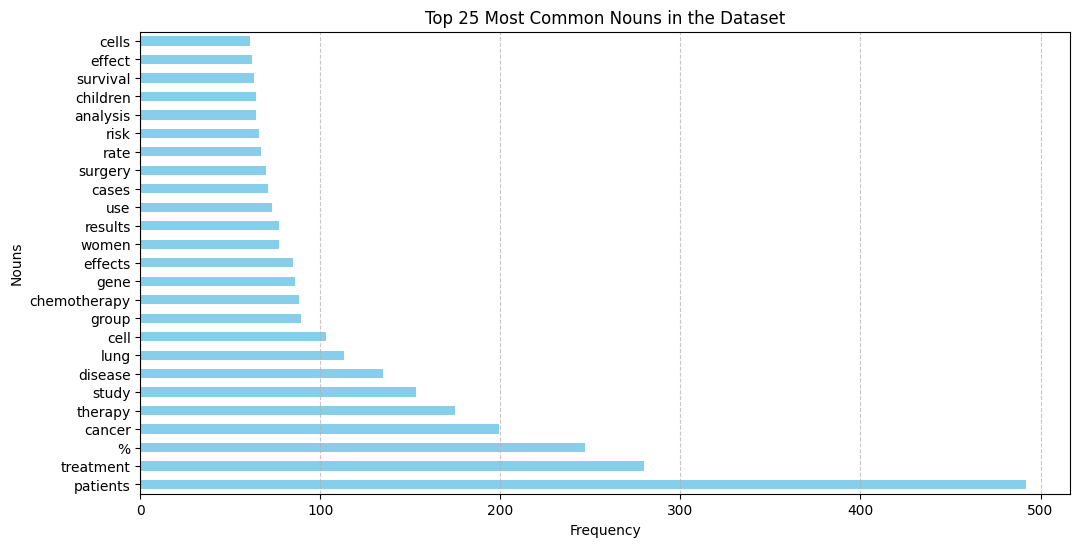

In [12]:
# Bar Plot
import matplotlib.pyplot as plt

# Create a horizontal bar chart
plt.figure(figsize=(12, 6))
top25_noun_counts_freq.plot(kind='barh', color='skyblue')

# Add labels and title
plt.xlabel("Frequency")
plt.ylabel("Nouns")
plt.title("Top 25 Most Common Nouns in the Dataset")
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

## Defining features for CRF





In [13]:
def getFeaturesForOneWord(sentence, pos):
    doc = model(" ".join(sentence))  # Process the entire sentence
    
    token = doc[pos]
    word = sentence[pos]

    features = [
        'word.lower=' + word.lower(),  # Serves as word ID
        'word[:5]=' + word[:5],        # First five characters
        'word[:4]=' + word[:4],        # First four characters
        'word[-7:]=' + word[-7:],      # Last seven characters
        'word[-6:]=' + word[-6:],      # Last six characters
        'word[-5:]=' + word[-5:],      # Last five characters
        'word[-4:]=' + word[-4:],      # Last four characters
        'word[-3:]=' + word[-3:],      # Last three characters
        'word.isupper=%s' % word.isupper(),  # Is the word in all uppercase
        'word.isdigit=%s' % word.isdigit(),  # Is the word a number
        'word.istitle=%s' % word.istitle(),  # Is the word in title case
        'word.isstopword=%s' % (word.lower() in STOP_WORDS),  # Is the word a stop word
        'word.isenglish=%s' % (word.lower() in english_words), # Is the word a common english word
        'word.postag=' + token.pos_,  # POS tag
        'word.dep=' + token.dep_,  # Dependency relation
        'word.ent_type=' + token.ent_type_,  # Named Entity type
        'word.ent_iob=' + token.ent_iob_,  # Inside-Outside-Beginning entity tagging
    ]
    
    # Previous Word Features
    if pos > 0:
        prev_word = sentence[pos - 1]
        prev_token = doc[pos - 1]
        features.extend([
            'prev_word.lower=' + prev_word.lower(),
            'prev_word.isupper=%s' % prev_word.isupper(),
            'prev_word.isdigit=%s' % prev_word.isdigit(),
            'prev_word.istitle=%s' % prev_word.istitle(),
            'prev_word.isstopword=%s' % (prev_word.lower() in STOP_WORDS),
            'prev_word.isenglish=%s' % (prev_word.lower() in english_words),
            'prev_word.postag=' + prev_token.pos_,
            'prev_word.dep=' + prev_token.dep_, 
            'prev_word.ent_type=' + prev_token.ent_type_,  
            'prev_word.ent_iob=' + prev_token.ent_iob_,  
        ])
    else:
        features.append('BEG')  # Feature to track beginning of sentence

    # Next Word Features
    if pos < len(sentence) - 1:
        next_word = sentence[pos + 1]
        next_token = doc[pos + 1]
        features.extend([
            'next_word.lower=' + next_word.lower(),
            'next_word.isupper=%s' % next_word.isupper(),
            'next_word.isdigit=%s' % next_word.isdigit(),
            'next_word.istitle=%s' % next_word.istitle(),
            'next_word.isstopword=%s' % (next_word.lower() in STOP_WORDS),
            'next_word.isenglish=%s' % (next_word.lower() in english_words),
            'next_word.postag=' + next_token.pos_,
            'next_word.dep=' + next_token.dep_, 
            'next_word.ent_type=' + next_token.ent_type_,  
            'next_word.ent_iob=' + next_token.ent_iob_,  
        ])
    else:
        features.append('END')  # Feature to track end of sentence

    return features


## Getting the features

### Write a code/function to get the features for a sentence

In [14]:
# Get features for a sentence.
def getFeaturesForOneSentence(sentence):
    sentence_list = sentence.split()
    return [getFeaturesForOneWord(sentence_list, pos) for pos in range(len(sentence_list))]

In [15]:
# Test the above function
getFeaturesForOneSentence(train_sentences[7])

[['word.lower=we',
  'word[:5]=We',
  'word[:4]=We',
  'word[-7:]=We',
  'word[-6:]=We',
  'word[-5:]=We',
  'word[-4:]=We',
  'word[-3:]=We',
  'word.isupper=False',
  'word.isdigit=False',
  'word.istitle=True',
  'word.isstopword=True',
  'word.isenglish=True',
  'word.postag=PRON',
  'word.dep=nsubj',
  'word.ent_type=',
  'word.ent_iob=O',
  'BEG',
  'next_word.lower=hypothesize',
  'next_word.isupper=False',
  'next_word.isdigit=False',
  'next_word.istitle=False',
  'next_word.isstopword=False',
  'next_word.isenglish=True',
  'next_word.postag=VERB',
  'next_word.dep=ROOT',
  'next_word.ent_type=',
  'next_word.ent_iob=O'],
 ['word.lower=hypothesize',
  'word[:5]=hypot',
  'word[:4]=hypo',
  'word[-7:]=thesize',
  'word[-6:]=hesize',
  'word[-5:]=esize',
  'word[-4:]=size',
  'word[-3:]=ize',
  'word.isupper=False',
  'word.isdigit=False',
  'word.istitle=False',
  'word.isstopword=False',
  'word.isenglish=True',
  'word.postag=VERB',
  'word.dep=ROOT',
  'word.ent_type=',
  '

### Write a code/function to get the labels of a sentence

In [16]:
# Get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
    return labels.split()

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [17]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in tqdm(train_sentences)]
X_test = [getFeaturesForOneSentence(sentence) for sentence in tqdm(test_sentences)]

100%|██████████| 1056/1056 [03:23<00:00,  5.18it/s]


### Define the labels as the target variable for test and the train dataset

In [18]:
Y_train = [getLabelsInListForOneSentence(labels) for labels in tqdm(train_labels)]
Y_test = [getLabelsInListForOneSentence(labels) for labels in tqdm(test_labels)]

100%|██████████| 1056/1056 [00:00<00:00, 347496.08it/s]


## Build the CRF Model

In [19]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    max_iterations=100, 
    all_possible_transitions=True,
    c1=0.1,
    c2=0.1,
)
crf.fit(X_train, Y_train)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    max_iterations=100)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [20]:
Y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [21]:
metrics.flat_f1_score(Y_test, Y_pred, average='weighted')

0.9264396756936187

In [22]:
from sklearn_crfsuite.metrics import flat_classification_report
print(flat_classification_report(Y_test, Y_pred, digits=4))

              precision    recall  f1-score   support

           D     0.8093    0.6614    0.7279      1450
           O     0.9457    0.9770    0.9611     16127
           T     0.7824    0.5802    0.6663      1041

    accuracy                         0.9302     18618
   macro avg     0.8458    0.7395    0.7851     18618
weighted avg     0.9259    0.9302    0.9264     18618



#### Observation: Due to class imbalance recall of the classes 'D' and 'T' are low indicating that the model struggles to correctly identify them.

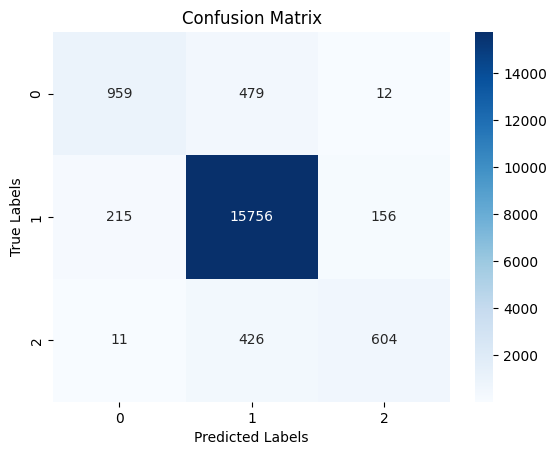

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_test_flat = np.concatenate(Y_test)
Y_pred_flat = np.concatenate(Y_pred)
# confusion_matrix(Y_test_flat, Y_pred_flat)
cm = confusion_matrix(Y_test_flat, Y_pred_flat)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

## Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

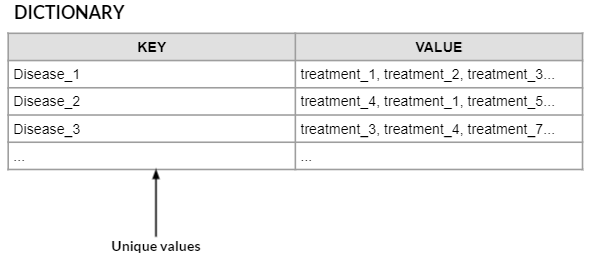

In [24]:
def map_diseases_to_treatments(sentences, predictions):
    disease_treatment_map = {} 
    
    for sentence, prediction in zip(sentences, predictions):
        words = sentence.split()  

        diseases = []
        treatments = []
        
        current_disease = []
        current_treatment = []
        
        for word, label in zip(words, prediction):
            if label == 'D':  
                current_disease.append(word)  
            else:
                if current_disease:  
                    diseases.append(" ".join(current_disease))
                    current_disease = []  

            if label == 'T':  
                current_treatment.append(word)  
            else:
                if current_treatment:  
                    treatments.append(" ".join(current_treatment))
                    current_treatment = []  
        
        # Handles word at the end of sentence
        if current_disease:
            diseases.append(" ".join(current_disease))
        if current_treatment:
            treatments.append(" ".join(current_treatment))
        
        if diseases and treatments:
            for disease in diseases:
                if disease in disease_treatment_map:
                    disease_treatment_map[disease].extend(treatments)  
                else:
                    disease_treatment_map[disease] = treatments.copy()  
    
    # Remove duplicates in treatment lists
    for disease in disease_treatment_map:
        disease_treatment_map[disease] = list(set(disease_treatment_map[disease]))  

    return disease_treatment_map

In [25]:
disease_treatment_dict = map_diseases_to_treatments(test_sentences, Y_pred)

In [26]:
pd.DataFrame(
    [(disease, ", ".join(treatments)) for disease, treatments in disease_treatment_dict.items()],
    columns=["Disease", "Treatments"]
)

,Disease,Treatments
0,macrosomic infants in gestational diabetes cases,good glycemic control
1,retinoblastoma,radiotherapy
2,epilepsy,Methylphenidate
3,ADHD,Methylphenidate
4,spontaneous major haemorrhage,warfarin
...,...,...
181,stable asthma,aerosolized salbutamol
182,Poliomyelitis,live oral poliovirus vaccines
183,glaucoma,Brimonidine tartrate
184,total peripheral artery occlusions,angioscopic


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [27]:
disease_treatment_dict.get('hereditary retinoblastoma', 'Not Found')

'Not Found'

### Predict the treatment for the disease name: 'retinoblastoma'

In [28]:
disease_treatment_dict.get('retinoblastoma', 'Not Found')

['radiotherapy']